In [279]:
from sklearn.svm import SVC,NuSVC, SVR, LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline,make_pipeline
import numpy as np
import pandas as pd
from q_value_calc_crosslinks import calcQ
from idXML2df_all_hits import readAndProcessIdXMLAllHits
import matplotlib.pyplot as plt
import re

In [280]:
input_file = "../data/crosslink_data/AChernev_080219_HeLa_RNA_UV.pkl"
input_file_perc = "../data/crosslink_data/AChernev_080219_HeLa_RNA_UV_opti_.pkl"
#input_file = "../data/crosslink_data/M_Raabe_A_Wulf_220421_270421_Expl3_Ecoli_XL_UV_S30_LB_bRPfrac_11.pkl" # rank 0
#input_file_perc = "../data/crosslink_data/M_Raabe_A_Wulf_220421_270421_Expl3_Ecoli_XL_UV_S30_LB_bRPfrac_11_perc.pkl" # rank 0 - 7
#input_file = "../data/crosslink_data/M_Raabe_A_Wulf_220421_290421_Expl3_Ecoli_XL_DEB_S30_LB_bRPfrac_12.pkl" # rank 0
#input_file_perc = "../data/crosslink_data/M_Raabe_A_Wulf_220421_290421_Expl3_Ecoli_XL_DEB_S30_LB_bRPfrac_12_perc.pkl" # rank 0 - 7
#input_file = "../data/crosslink_data/MRaabe_LW_091221_171221_Expl2_XL_Ecoli_NM_S30_bRP_rep1_11.pkl" # rank 0
#input_file_perc = "../data/crosslink_data/MRaabe_LW_091221_171221_Expl2_XL_Ecoli_NM_S30_bRP_rep1_11_perc.pkl" # rank 0 - 7


In [281]:
original_df = pd.read_pickle(input_file)

def check_order(x):
    return x.loc[x.index[0],'PSMId'] == 1


# QUESTION: why is there a difference between Scan Nr and rank == 0
# should I rather use PSMId instead of the rank column?
print(len(np.unique(original_df['ScanNr'])))
print(np.count_nonzero(original_df['rank'] == 0))
print(np.count_nonzero(original_df['PSMId'] == 1))
original_df.sort_values(['Score', 'PSMId'],ascending=[False, True], inplace=True)
result = original_df.groupby('ScanNr', sort=False).apply(lambda x: check_order(x))
print(np.all(result))
#def test(x):
#    return np.any(x != 1)
#print(np.apply_along_axis(test,1, np.array(result.values)))

30275
27077
30275
True


C:\Users\mail\AppData\Local\Temp\ipykernel_3440\602480884.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = original_df.groupby('ScanNr', sort=False).apply(lambda x: check_order(x))


In [282]:
original_df = pd.read_pickle(input_file)
original_df_rank_0 = original_df.loc[original_df['PSMId'] == 1,:]
q_vals_before = calcQ(original_df_rank_0)
perc_df = pd.read_pickle(input_file_perc)
perc_df = perc_df.loc[perc_df['PSMId'] == 1,:]
q_vals_perc = calcQ(perc_df)

features = ['Score','peplen', 'NuXL:isXL', 'NuXL:modds', 'NuXL:pl_modds', 
                'NuXL:mass_error_p', 'NuXL:tag_XLed', 'NuXL:tag_unshifted' ,
                'NuXL:tag_shifted', 'missed_cleavages', 'NuXL:ladder_score',
                'variable_modifications']

# filter data and sort according to score
df = original_df.filter(np.concatenate([features,['ScanNr', 'rank', 'Label', 'PSMId']]))
df = df.sort_values('Score',ascending=False)

# determine minority class 
minority_class = min({len(df.loc[df['NuXL:isXL'] == 0]), len(df.loc[df['NuXL:isXL'] == 1])})
class_threshold = 500
if (minority_class > class_threshold):
    print("truncating to " + str(class_threshold) + "\n") 
    minority_class = class_threshold
# define training data (peptides with top and bottom scores of each class with rank 0)
pep_top = df.loc[(df['NuXL:isXL'] == 0) & (df['PSMId'] == 1)][:int(minority_class/2)]
pep_bottom = df.loc[(df['NuXL:isXL'] == 0) & (df['PSMId'] == 1)][-int(minority_class/2):]
XL_top = df.loc[(df['NuXL:isXL'] == 1) & (df['PSMId'] == 1)][:int(minority_class/2)]
XL_bottom = df.loc[(df['NuXL:isXL'] == 1) & (df['PSMId'] == 1)][-int(minority_class/2):]
train_idx = np.concatenate([pep_top.index, pep_bottom.index, XL_top.index, XL_bottom.index])

c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(scoreColName, ascending=ascending, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace

truncating to 500



c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)


In [283]:
df.loc[pep_top.index,'label'] = 1
df.loc[pep_bottom.index,'label'] = 0
df.loc[XL_top.index,'label'] = 1
df.loc[XL_bottom.index,'label'] = 0


In [284]:
X = df
X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, 'label']

In [285]:
def set_new_rank(x):
    x.sort_values("Score",ascending=False,inplace=True)
    x["new_PSMId"] = range(1,len(x) + 1)
    return x

# initialise the k-fold cross validator
no_split = 5
kf = KFold(n_splits=no_split, shuffle=True, random_state=1)

param_grid = {
        'C': np.power(float(2), [-5,-1,1,5,7,11,15])
    }
# create the pipeline
pipe = make_pipeline(MinMaxScaler(), 
                        GridSearchCV(
                            estimator=SVC(kernel='linear', probability=True), 
                            param_grid=param_grid, 
                            n_jobs=-1,
                            scoring="accuracy",
                            cv=kf, 
                            refit=True))
pipe.fit(X_train, y_train)
X['Score_old'] = X['Score']
X['Score'] = 1.0 - pipe.predict_proba(X.loc[:,features])
# rerank PSMs
X = X.groupby("ScanNr")\
    .apply(
        # your typical transform function here
        lambda x: set_new_rank(x)
    )
X.index = X.index.droplevel('ScanNr')

# filter for rank = 0
X_rank_0 = X.loc[X['new_PSMId'] == 1,:]
# compute q-values
q_vals_after = calcQ(X_rank_0)

C:\Users\mail\AppData\Local\Temp\ipykernel_3440\77922065.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(scoreColName, ascending=ascending, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in

In [286]:
def get_target_id(
    scores: pd.DataFrame,                   # pd.DataFrame: Input data containing PSMs and q-values
    isXLColName: str = "NuXL:isXL",           # str: Column name indicating if the peptide is crosslinked
    label_col: str = "Label",              # str: Column name for the label, indicating target (1) or decoy
    q_val_col: str = "class-specific_q-val",
    max_qvalue: float = 0.1
):
    scores.sort_values("Score",ascending=False,inplace=True)
    # Initialize a dictionary to store counts of PSMs below each q-value threshold
    result = []
    for XL in [0,1]:
        XL_summary_q_val_count = []
        
        # Filter for crosslinked (XL) PSMs
        XL_psms_q_df = scores[scores[isXLColName] == XL]
        XL_psms_q_df.sort_values(['class-specific_q-val', 'Score'], ascending=[True, False], inplace=True)

        XL_q_value_thresholds = XL_psms_q_df[q_val_col]

        # Further filter to keep only target PSMs (label == 1)
        XL_psms_q_df = XL_psms_q_df[XL_psms_q_df[label_col] == 1]
        # Count the number of PSMs below each q-value threshold
        for qvalue in XL_q_value_thresholds:
            # Count XL PSMs below the class-specific q-value threshold
            XL_summary_q_val_count.append(sum(j <= min(qvalue, max_qvalue) for j in XL_psms_q_df[q_val_col]))
        result.append(XL_q_value_thresholds)
        result.append(XL_summary_q_val_count)

    return result

pep_q_value_thresholds_after, pep_target_id_after, XL_q_value_thresholds_after, XL_target_id_after = get_target_id(q_vals_after)
pep_q_value_thresholds_before, pep_target_id_before, XL_q_value_thresholds_before, XL_target_id_before  = get_target_id(q_vals_before)
pep_q_value_thresholds_perc, pep_target_id_perc, XL_q_value_thresholds_perc, XL_target_id_perc = get_target_id(q_vals_perc)

C:\Users\mail\AppData\Local\Temp\ipykernel_3440\2964883643.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XL_psms_q_df.sort_values(['class-specific_q-val', 'Score'], ascending=[True, False], inplace=True)


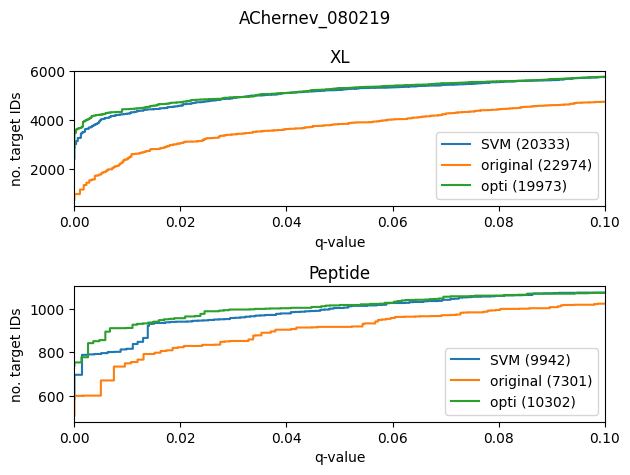

In [287]:
fig, axs = plt.subplots(2)
axs[0].step(XL_q_value_thresholds_after,XL_target_id_after, label=f"SVM ({len(XL_q_value_thresholds_after)})" )
axs[1].step(pep_q_value_thresholds_after,pep_target_id_after, label=f"SVM ({len(pep_q_value_thresholds_after)})")
axs[0].step(XL_q_value_thresholds_before,XL_target_id_before, label=f"original ({len(XL_q_value_thresholds_before)})" )
axs[1].step(pep_q_value_thresholds_before,pep_target_id_before, label = f"original ({len(pep_q_value_thresholds_before)})")
axs[0].step(XL_q_value_thresholds_perc,XL_target_id_perc, label=f"opti ({len(XL_q_value_thresholds_perc)})")
axs[1].step(pep_q_value_thresholds_perc,pep_target_id_perc, label=f"opti ({len(pep_q_value_thresholds_perc)})")
axs[0].set_xlim(0,0.1)
axs[1].set_xlim(0,0.1)
axs[0].set_title("XL")
axs[1].set_title("Peptide")
axs[0].set_xlabel("q-value")
axs[1].set_xlabel("q-value")
axs[0].set_ylabel("no. target IDs")
axs[1].set_ylabel("no. target IDs")
axs[0].legend()
axs[1].legend()
str_title = re.search("_data/.*_(Expl|HeLa)", input_file).group()[6:-5]
fig.suptitle(str_title)
fig.tight_layout()
plt.show()

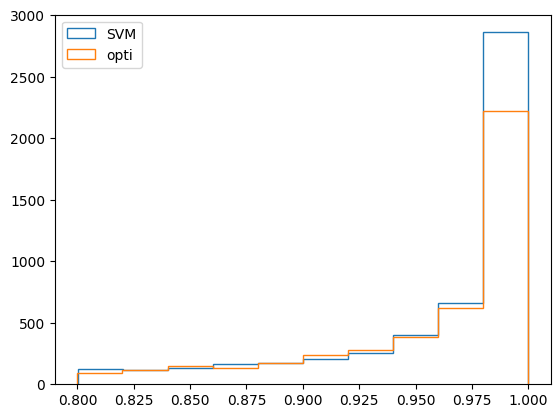

In [288]:
plt.hist(q_vals_after.loc[q_vals_after[q_vals_after['Score'] > 0.8].index, 'Score'], label = 'SVM', histtype='step')
plt.hist(q_vals_perc.loc[q_vals_perc[q_vals_perc['Score'] > 0.8].index, 'Score'], label='opti', histtype='step')
plt.legend()
plt.show()